####  Этап 1: Оценка проблемы — Сводный анализ отключений

#### На этом этапе мы анализируем таблицу `blackouts`, чтобы понять **масштаб, длительность и характер** проблемы отключения коммунальных услуг в целом.
 
#### **Цель:**
##### 1.  Оценить общее количество и продолжительность отключений.
##### 2.  Выявить самые проблемные типы услуг (электричество, вода, отопление).
##### 3.  Определить основные организации-инициаторы отключений.

In [27]:
# 1.1. Настройка окружения и загрузка данных

# Используем библиотеку `sqlite3` для подключения к базе данных и `pandas` для анализа и обработки данных.

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Установка опций отображения
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

sns.set_style("whitegrid")
# Подключение к базе данных
DB_PATH = '../databases/dataset.db' 
conn = sqlite3.connect(DB_PATH)

# Загрузка таблицы blackouts
query_blackouts = "SELECT * FROM blackouts;"
blackouts_df = pd.read_sql_query(query_blackouts, conn)

print(f"Загружено записей в blackouts: {len(blackouts_df)}")
blackouts_df.head()

Загружено записей в blackouts: 25264


,id,start_date,end_date,description,type,initiator_name,source
0,f88cefa506f44ebf8f010b8681b5449e,2018-01-01 00:08:00,2018-01-01 09:00:00,"Авария на сети электроснабжения, ведутся восст...",electricity,МУПВ ВПЭС (электрические сети Ленинского района),Единая дежурная диспетчерская служба города (Л...
1,38ddf6852801fa90cc70f9770239961e,2018-01-01 00:24:00,2018-01-01 10:00:00,"Авария на электролинии, остановка работы насос...",cold_water,МУПВ ВПЭС (электрические сети Ленинского района),Единая дежурная диспетчерская служба города (Л...
2,53c570099fe380dce9e56e2ace9cfa9c,2018-01-01 10:44:00,2018-01-02 18:00:00,Авария в системе водоснабжения дома. Жителям н...,hot_water,"ООО ""Управляющая компания ""Регион-ЖКХ""","Аварийная служба ООО ""Мадикс"""
3,9c1b9ebbd9a698eef046b27cb3568745,2018-01-01 11:32:00,2018-01-01 15:00:00,"Авария на сети электроснабжения, ведутся восст...",electricity,МУПВ ВПЭС (электрические сети Фрунзенского рай...,Единая дежурная диспетчерская служба города (Ф...
4,8aa631cb343aac0731bbde806dfa6d8c,2018-01-01 11:33:00,2018-01-01 15:00:00,"Авария на электролинии, остановка работы насос...",hot_water,МУПВ ВПЭС (электрические сети Фрунзенского рай...,Единая дежурная диспетчерская служба города (Ф...


In [28]:
# 1.2. Подготовка данных: Расчет длительности

# Конвертируем столбцы с датами в формат datetime и рассчитываем продолжительность каждого отключения в часах.

# Преобразование столбцов с датами в формат datetime
blackouts_df['start_date'] = pd.to_datetime(blackouts_df['start_date'])
blackouts_df['end_date'] = pd.to_datetime(blackouts_df['end_date'])

# Расчет длительности отключения (timedelta)
blackouts_df['duration'] = blackouts_df['end_date'] - blackouts_df['start_date']

# Расчет длительности в часах (для удобства анализа)
blackouts_df['duration_hours'] = blackouts_df['duration'].dt.total_seconds() / 3600

# Удаление записей с отрицательной или нулевой длительностью (ошибочные данные или мгновенные события)
blackouts_df = blackouts_df[blackouts_df['duration_hours'] > 0]

print(f"Количество записей после очистки: {len(blackouts_df)}")
blackouts_df[['start_date', 'end_date', 'duration', 'duration_hours']].describe()

Количество записей после очистки: 25264


,start_date,end_date,duration,duration_hours
count,25264,25264,25264,25264.000000
mean,2018-12-29 18:52:18.816497408,2018-12-31 02:06:20.649936640,1 days 07:14:01.833438885,31.233843
min,2018-01-01 00:08:00,2018-01-01 09:00:00,0 days 00:01:00,0.016667
25%,2018-07-08 09:36:00,2018-07-12 12:00:00,0 days 02:52:00,2.866667
50%,2018-12-27 16:36:00,2018-12-28 08:14:30,0 days 04:41:00,4.683333
75%,2019-06-18 11:14:00,2019-06-19 16:00:00,0 days 10:45:00,10.750000
max,2019-12-31 20:29:00,2020-01-09 12:00:00,355 days 23:13:00,8543.216667
std,NaN,NaN,6 days 16:21:31.850660568,160.358847


In [29]:
#  1.3. Сводный анализ длительности и частоты

# Рассчитаем ключевые метрики, чтобы оценить общий масштаб проблемы для пользователей.


# Общее количество отключений
total_blackouts = len(blackouts_df)

# Общая длительность отключений (в часах и днях)
total_duration_hours = blackouts_df['duration_hours'].sum()
total_duration_days = total_duration_hours / 24

# Статистика по длительности одного отключения
avg_duration = blackouts_df['duration_hours'].mean()
median_duration = blackouts_df['duration_hours'].median()
max_duration = blackouts_df['duration_hours'].max()

print("--- Общие метрики отключений ---")
print(f"Всего отключений: {total_blackouts:,}")
print(f"Общее время, проведенное без услуг (суммарно по всем отключениям):")
print(f"  {total_duration_hours:,.2f} часов, или {total_duration_days:,.2f} дней")
print("-" * 35)
print("Статистика длительности одного отключения (часы):")
print(f"  Средняя длительность: {avg_duration:.2f} ч.")
print(f"  Медианная длительность: {median_duration:.2f} ч. (более устойчивый показатель)")
print(f"  Максимальная длительность: {max_duration:.2f} ч.")



--- Общие метрики отключений ---
Всего отключений: 25,264
Общее время, проведенное без услуг (суммарно по всем отключениям):
  789,091.80 часов, или 32,878.83 дней
-----------------------------------
Статистика длительности одного отключения (часы):
  Средняя длительность: 31.23 ч.
  Медианная длительность: 4.68 ч. (более устойчивый показатель)
  Максимальная длительность: 8543.22 ч.


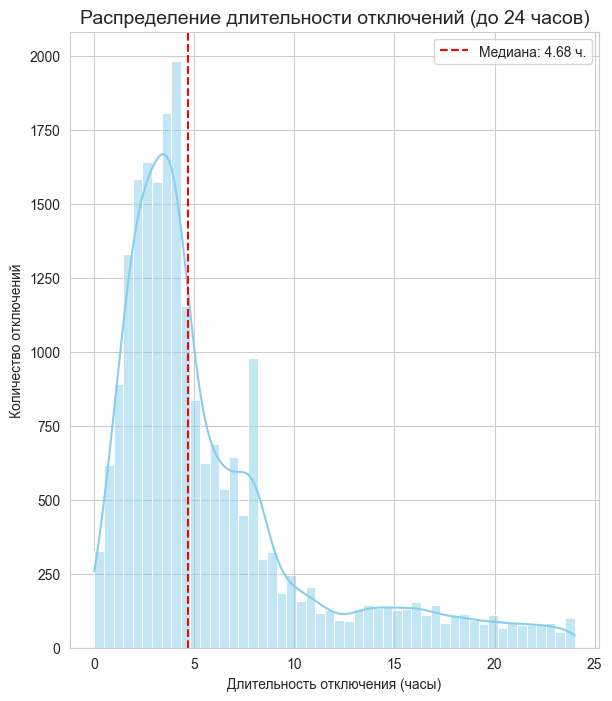

In [30]:
## 1.3.1. Визуализация распределения длительности

# Поскольку длительность имеет очень длинный хвост (макс 8543 ч.),
# визуализируем только основную часть данных (до 24 часов) для наглядности
max_duration_for_plot = 24
df_plot = blackouts_df[blackouts_df['duration_hours'] <= max_duration_for_plot]

plt.figure(figsize=(15, 8))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_plot['duration_hours'], bins=50, kde=True, color='skyblue')
plt.axvline(blackouts_df['duration_hours'].median(), color='red', linestyle='--', label=f'Медиана: {blackouts_df["duration_hours"].median():.2f} ч.')
plt.title(f'Распределение длительности отключений (до {max_duration_for_plot} часов)', fontsize=14)
plt.xlabel('Длительность отключения (часы)')
plt.ylabel('Количество отключений')
plt.legend()

plt.show()

 **Вывод по сводному анализу:**

 Проблема отключений характеризуется высокой частотой (более 25 тысяч событий) и ощутимой продолжительностью (медиана 4.68 часа).



--- Анализ отключений по типу услуги ---
             count  total_duration_hours  average_duration_hours  median_duration_hours  count_share
type                                                                                                
hot_water     9339             650733.10                   69.68                   6.00        36.97
cold_water    9109              93630.82                   10.28                   4.65        36.06
electricity   4745              21933.92                    4.62                   3.20        18.78
heat          2071              22793.97                   11.01                   5.25         8.20


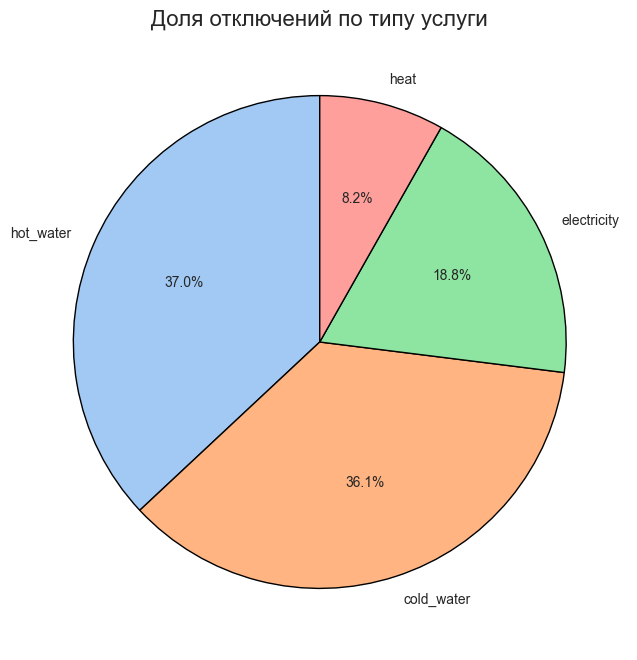

In [31]:

# ## 1.4. Анализ по типу услуг (`type`)
# Распределение отключений по типам услуг (`electricity`, `water`, `heating`) для выявления наиболее критичных областей.

type_analysis = blackouts_df.groupby('type').agg(
    count=('id', 'count'),
    total_duration_hours=('duration_hours', 'sum'),
    average_duration_hours=('duration_hours', 'mean'),
    median_duration_hours=('duration_hours', 'median')
).sort_values(by='count', ascending=False)

# Добавление столбца с долей от общего числа отключений
type_analysis['count_share'] = (type_analysis['count'] / total_blackouts) * 100

print("--- Анализ отключений по типу услуги ---")
print(type_analysis.round(2))

# Используем результаты анализа из ячейки 1.4
type_analysis = blackouts_df.groupby('type').agg(
    count=('id', 'count')
).sort_values(by='count', ascending=False)

plt.figure(figsize=(8, 8))
plt.pie(
    type_analysis['count'],
    labels=type_analysis.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel"),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Доля отключений по типу услуги', fontsize=16)
plt.ylabel('') # Убираем лишнюю подпись Y
plt.show()


Вывод по Анализу Отключений по Типу Услуг

Ключевые наблюдения и их значение:
1) Горячая вода (hot_water)	Доля в общем числе: 36.97%,	Медианная длительность: 6.00 , Средняя длительность: 69.68.
Самый частый тип отключений и самый продолжительный по медиане. 

2) Холодная вода (cold_water)	Доля в общем числе: 36.06%, Медианная длительность: 4.65 ч,  Средняя длительность: 10.28.
Почти столь же часто, как горячая вода. Продолжительность также высока.

3) Электричество (electricity)	Доля в общем числе: 18.78%, Медианная длительность: 3.20 ч,  Средняя длительность: 4.62.
Менее часто, но всё еще значительно. Имеет самую низкую медианную длительность.

4) Отопление (heat)	Доля в общем числе: 8.20%, Медианная длительность: 5.25 ч,  Средняя длительность: 11.01.
Наименее частый, но имеет вторую по продолжительности медиану.

electricity: средняя длительность = 4.62 ч, записи = 4745 -> hist_electricity.png


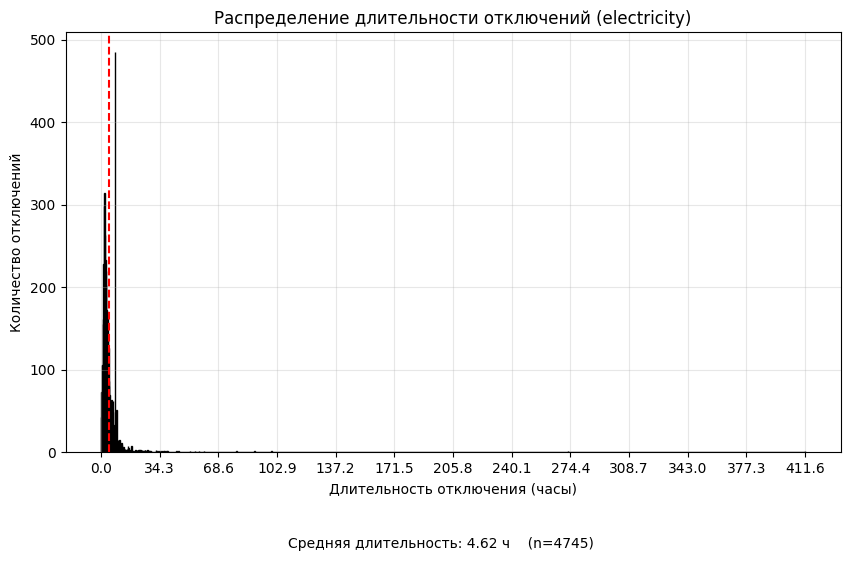

cold_water: средняя длительность = 10.28 ч, записи = 9109 -> hist_cold_water.png


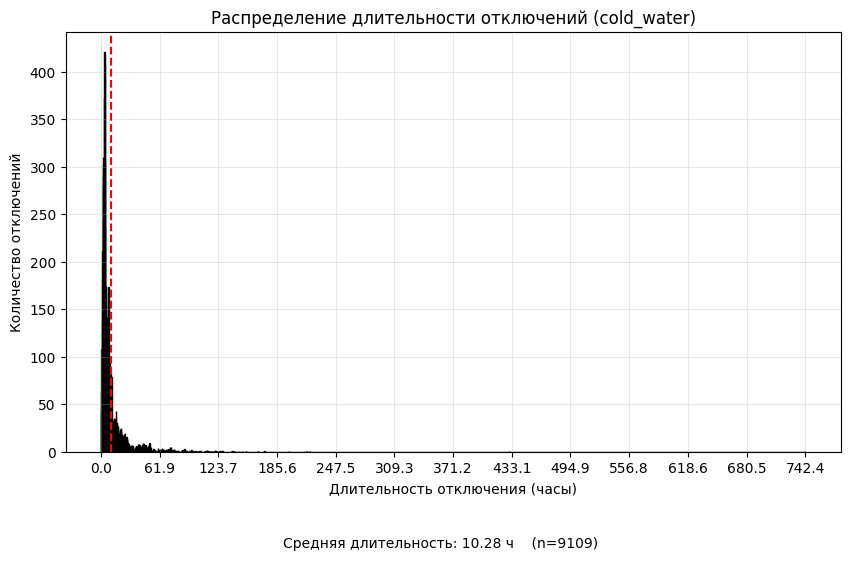

hot_water: средняя длительность = 69.68 ч, записи = 9339 -> hist_hot_water.png


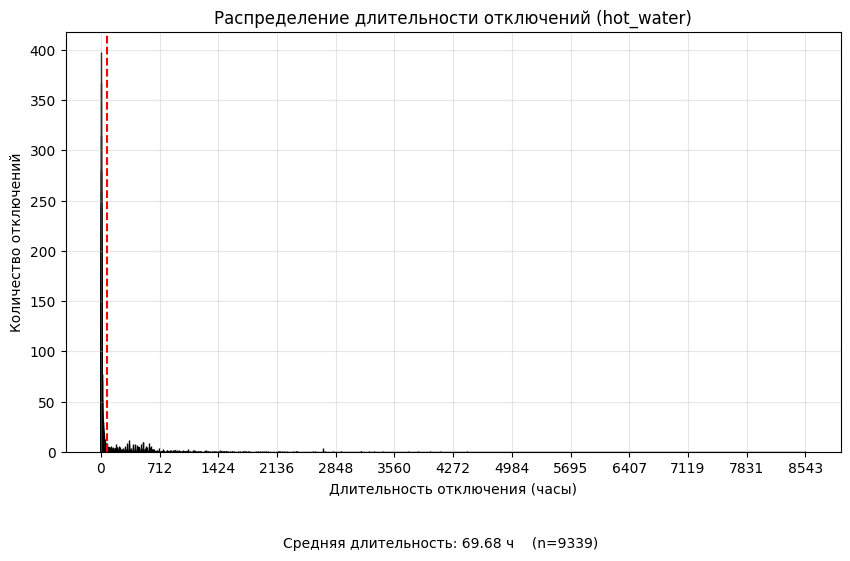

heat: средняя длительность = 11.01 ч, записи = 2071 -> hist_heat.png


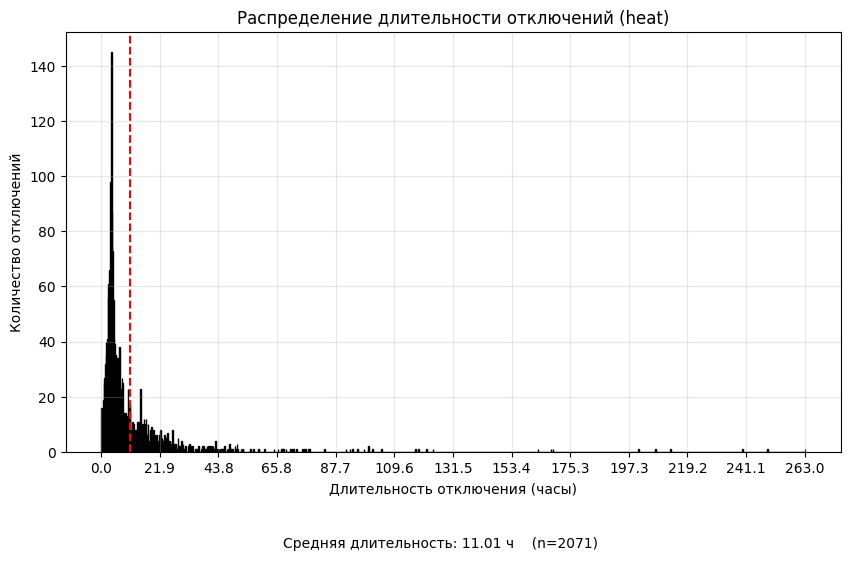

Все графики отображены.


In [1]:
# ...existing code...
import os
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

DB_PATH = '../databases/dataset.db'
BIN_WIDTH_HOURS = 0.25  # 15 минут

def calculate_duration_hours(start_date, end_date):
    """Вернуть длительность в часах или None при некорректных/пустых датах."""
    if not start_date or not end_date:
        return None
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d'):
        try:
            start = datetime.strptime(start_date, fmt)
            end = datetime.strptime(end_date, fmt)
            duration_h = (end - start).total_seconds() / 3600.0
            return duration_h if duration_h >= 0 else 0.0
        except (ValueError, TypeError):
            continue
    return None

def safe_filename(s):
    return "".join(c if c.isalnum() or c in '._-' else '_' for c in str(s)).strip('_')

def plot_histogram_for_type(blackout_type, durations):
    max_val = max(48, max(durations))  # минимум 48 часов охвата
    bins = np.arange(0, max_val + BIN_WIDTH_HOURS, BIN_WIDTH_HOURS)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(durations, bins=bins, edgecolor='black', color='#69b3a2')
    mean_hours = float(np.mean(durations))

    # Вертикальная линия среднего
    ax.axvline(mean_hours, color='red', linestyle='--', linewidth=1.5)

    # Подписи и сетка
    ax.set_title(f'Распределение длительности отключений ({blackout_type})')
    ax.set_xlabel('Длительность отключения (часы)')
    ax.set_ylabel('Количество отключений')
    ax.grid(True, alpha=0.3)

    # Настройка делений по X для читаемости
    xticks = np.linspace(0, max_val, num=13)
    ax.set_xticks(np.round(xticks, 2))

    # Оставляем место внизу и добавляем подпись среднего под гистограммой
    plt.subplots_adjust(bottom=0.18)
    plt.figtext(0.5, 0.02, f'Средняя длительность: {mean_hours:.2f} ч    (n={len(durations)})',
                ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # Сохранение и показ
    outname = f'hist_{safe_filename(blackout_type)}.png'
    plt.savefig(outname, dpi=150, bbox_inches='tight')
    print(f"{blackout_type}: средняя длительность = {mean_hours:.2f} ч, записи = {len(durations)} -> {outname}")
    plt.show()
    plt.close(fig)

def main(db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    try:
        cursor.execute("SELECT DISTINCT type FROM blackouts")
        types = [row[0] for row in cursor.fetchall()]

        for blackout_type in types:
            cursor.execute("""
                SELECT start_date, end_date
                FROM blackouts
                WHERE type = ?
            """, (blackout_type,))

            durations = []
            for row in cursor.fetchall():
                start_date, end_date = row
                dur = calculate_duration_hours(start_date, end_date)
                if dur is not None:
                    durations.append(dur)

            if not durations:
                print(f"Нет данных для типа '{blackout_type}'")
                continue

            plot_histogram_for_type(blackout_type, durations)

    finally:
        conn.close()
        print("Все графики отображены.")

if __name__ == '__main__':
    main()
# ...existing code...

In [32]:
# ## 1.5. Анализ по инициатору (`initiator_name`)
# Выявление организаций, которые чаще всего являются инициаторами работ и, как следствие, отключений.

initiator_analysis = blackouts_df.groupby('initiator_name').agg(
    count=('id', 'count'),
    total_duration_hours=('duration_hours', 'sum'),
    median_duration_hours=('duration_hours', 'median')
).sort_values(by='count', ascending=False).head(10)

print("--- ТОП-10 Инициаторов отключений ---")
print(initiator_analysis.round(2))

--- ТОП-10 Инициаторов отключений ---
                                                 count  total_duration_hours  median_duration_hours
initiator_name                                                                                     
МУПВ ВПЭС (электрические сети)                    2431              13134.85                   4.12
КГУП «Приморский водоканал»                       1415              13918.03                   7.13
ООО "Мингородок"                                   875               5716.98                   3.72
ООО "Невельского"                                  777               7795.53                   4.10
МУПВ ВПЭС (тепловые сети Первомайского района)     751              98234.93                  14.27
МУПВ ВПЭС (тепловые сети)                          699             122782.58                  24.02
ООО "УК "Комплекс коммунальных услуг"              624              11153.87                   6.57
ООО "Управляющая компания Первомайского района"    592        

Вывод по Анализу Инициаторов Отключений
Анализ ТОП-10 инициаторов отключений показывает, какие организации генерируют наибольшее количество проблем и определяют самые продолжительные простои, что является важным контекстом для обоснования фичи предсказания.

Ключевые наблюдения:

Лидеры по частоте:

Наибольшее количество отключений приходится на МУПВ ВПЭС (электрические сети) (2431 случай) и КГУП «Приморский водоканал» (1415 случаев). Это логично, поскольку они отвечают за наиболее частые типы отключений (электричество и вода), как показано в Выводе 1.4.

Лидеры по продолжительности (по медиане):

МУПВ ВПЭС (тепловые сети) (медиана 24.02 ч.) и МУПВ ВПЭС (тепловые сети Первомайского района) (медиана 14.27 ч.) ответственны за отключения с самой высокой медианной длительностью.

Эти данные указывают, что хотя отключения тепла и горячей воды (за которые они в основном отвечают) происходят реже, чем отключения электроэнергии, их устранение занимает значительно больше времени.

Управляющие компании (УК):

В списке также присутствует значительное количество управляющих компаний (например, ООО "Мингородок", ООО "Невельского", ООО "УК "Комплекс коммунальных услуг"), что говорит о том, что существенная доля проблем связана не только с магистральными сетями, но и с внутридомовыми авариями или работами, которые проводятся самими УК.

Значение для фичи предсказания:
Выявление инициаторов позволяет понять, что проблема имеет две основные природы:

1) Массовые и относительно короткие проблемы (Электричество/Вода от крупных сетевых организаций).

2) Редкие, но крайне продолжительные проблемы (Отопление/Горячая вода от тепловых сетей).

Вывод: Поскольку отключения, инициированные тепловыми сетями ВПЭС, длятся многократно дольше (медиана до 24 часов) по сравнению с другими (медиана 3-7 часов), предсказание времени восстановления для этих событий имеет наивысшую пользовательскую ценность. Необходимость провести сутки без отопления или горячей воды требует максимально точного и своевременного информирования.

### Сводный Итог Этапа 1
Анализ таблицы blackouts:

Масштаб: Более 25 тысяч отключений и почти 800 тысяч совокупных часов простоя демонстрируют высокий риск для пользователей.

Актуальность: Типичное отключение длится около 5 часов (медиана), что достаточно долго для создания серьезных неудобств.

Критичность: Проблемы с теплом и водой (особенно инициированные тепловыми сетями МУПВ ВПЭС) являются самыми продолжительными (медиана до 24 часов).

### Этап 2: Географическое распределение проблемы (Пострадавшие здания и районы)

 На этом этапе мы свяжем данные об отключениях (`blackouts`) с географической информацией (`buildings`, `districts`, `folk_districts`), чтобы показать, что проблема распределена **неравномерно** и сконцентрирована в определенных зонах.

 **Цель:**
1.  Оценить общее число зданий, затронутых отключениями.
2.  Выявить самые проблемные **Официальные районы** (`districts`) по частоте и длительности отключений.
3.  Выявить самые проблемные **Неофициальные районы** (`folk_districts`).

In [33]:
#  2.1. Загрузка и подготовка данных

# Загружаем необходимые таблицы (`buildings`, `blackouts_buildings`, `districts`, `folk_districts`) и выполняем первичное объединение.

import sqlite3
import pandas as pd
import numpy as np

# Установка опций отображения
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Предполагается, что conn уже установлен из Этапа 1
DB_PATH = '../databases/dataset.db' 
conn = sqlite3.connect(DB_PATH)

# Загрузка дополнительных таблиц
query_bb = "SELECT * FROM blackouts_buildings;"
blackouts_buildings_df = pd.read_sql_query(query_bb, conn)

query_buildings = "SELECT id, district_id, folk_district_id, big_folk_district_id, is_fake FROM buildings;"
buildings_df = pd.read_sql_query(query_buildings, conn)

query_districts = "SELECT id, name FROM districts;"
districts_df = pd.read_sql_query(query_districts, conn)

query_folk_districts = "SELECT id, name FROM folk_districts;"
folk_districts_df = pd.read_sql_query(query_folk_districts, conn)

# Используем blackouts_df с duration_hours из Этапа 1
# Если blackouts_df не сохранен, его нужно загрузить и обработать снова:
if 'blackouts_df' not in locals():
    blackouts_df = pd.read_sql_query("SELECT id, start_date, end_date, type FROM blackouts;", conn)
    blackouts_df['start_date'] = pd.to_datetime(blackouts_df['start_date'])
    blackouts_df['end_date'] = pd.to_datetime(blackouts_df['end_date'])
    blackouts_df['duration'] = blackouts_df['end_date'] - blackouts_df['start_date']
    blackouts_df['duration_hours'] = blackouts_df['duration'].dt.total_seconds() / 3600
    blackouts_df = blackouts_df[blackouts_df['duration_hours'] > 0] # Очистка

print(f"Всего отключений: {len(blackouts_df)}")
print(f"Связей отключение-здание: {len(blackouts_buildings_df)}")
print(f"Всего зданий: {len(buildings_df)}")

Всего отключений: 25264
Связей отключение-здание: 175590
Всего зданий: 58199


In [34]:
# ## 2.2. Оценка охвата зданий

# Выясним, какое количество уникальных зданий было затронуто отключениями, чтобы оценить общий охват проблемы.

# Уникальные здания, затронутые хотя бы одним отключением
affected_buildings_count = blackouts_buildings_df['building_id'].nunique()
total_buildings_count = buildings_df['id'].nunique()

print("--- Оценка охвата зданий ---")
print(f"Общее количество уникальных зданий в базе: {total_buildings_count:,}")
print(f"Количество зданий, затронутых отключениями: {affected_buildings_count:,}")
print(f"Процент затронутых зданий: {(affected_buildings_count / total_buildings_count * 100):.2f}%")

--- Оценка охвата зданий ---
Общее количество уникальных зданий в базе: 58,199
Количество зданий, затронутых отключениями: 21,159
Процент затронутых зданий: 36.36%


In [35]:
# ## 2.3. Анализ по Официальным Районам (`districts`)
# 
# Объединяем данные, чтобы получить метрики отключений по официальным административным районам.
# 
# **Схема объединения:** # `blackouts` $\rightarrow$ `blackouts_buildings` $\rightarrow$ `buildings` $\rightarrow$ `districts`

# %%
# 1. Объединение отключений и зданий
blackouts_with_buildings = blackouts_buildings_df.merge(
    blackouts_df[['id', 'duration_hours']],
    left_on='blackout_id',
    right_on='id',
    how='inner'
).rename(columns={'id': 'blackout_id_clean'}) # Переименовываем id отключения, чтобы не путать

# 2. Добавление информации о районах к отключениям
blackouts_with_geo = blackouts_with_buildings.merge(
    buildings_df[['id', 'district_id']],
    left_on='building_id',
    right_on='id',
    how='inner'
).rename(columns={'id': 'building_id_clean'})

# 3. Группировка и агрегация по Официальному району
district_analysis = blackouts_with_geo.groupby('district_id').agg(
    total_blackouts=('blackout_id', 'nunique'), # Считаем уникальные отключения
    total_duration_hours=('duration_hours', 'sum'),
    median_duration_hours=('duration_hours', 'median')
)

district_analysis = district_analysis.reset_index().merge( # Сброс индекса, чтобы district_id стал столбцом
    districts_df.rename(columns={'id': 'district_id', 'name': 'district_name'}),
    on='district_id',
    how='left'
).set_index('district_name').sort_values(by='total_blackouts', ascending=False)


# Дополнительно: Количество уникальных зданий в каждом районе (для нормализации)
buildings_per_district = buildings_df.groupby('district_id')['id'].nunique().to_frame('total_buildings')
# ИСПРАВЛЕНИЕ: Сбрасываем индекс district_id, чтобы он стал столбцом для слияния
buildings_per_district = buildings_per_district.reset_index() 

# Теперь buildings_per_district содержит столбец 'district_id'.
# districts_df содержит 'id' и 'name'.
# Слияние для получения имени района:
buildings_per_district = buildings_per_district.merge(
    districts_df, 
    left_on='district_id', # Используем district_id из buildings_per_district
    right_on='id',         # Используем id из districts_df
    how='left'
).set_index('name')['total_buildings'] # Устанавливаем name как индекс и выбираем нужный столбец

# Финальное слияние: используем left_index=True для слияния по индексу (названию района)
district_analysis = district_analysis.merge(
    buildings_per_district, 
    left_index=True, 
    right_index=True, 
    how='left'
)

# Нормализация: частота отключений на одно здание
district_analysis['blackouts_per_building'] = district_analysis['total_blackouts'] / district_analysis['total_buildings']

print("--- Анализ отключений по Официальным районам ---")
print(district_analysis[['total_blackouts', 'blackouts_per_building', 'median_duration_hours', 'total_duration_hours']].head(10).round(2))

--- Анализ отключений по Официальным районам ---
                      total_blackouts  blackouts_per_building  median_duration_hours  total_duration_hours
district_name                                                                                             
Ленинский район                  7684                    1.86                   8.68            2675451.77
Первомайский район               6518                    1.75                   8.00            1927361.70
Первореченский район             5778                    1.47                   8.00            1999635.88
Советский район                  3214                    0.17                   8.00            1963813.60
Фрунзенский район                2389                    0.70                   8.10            1558756.43


Вывод по Анализу Отключений в Официальных Районах
Анализ географического распределения отключений по официальным районам подтверждает, что проблема является локализованной и острой для определенных территорий.
Ключевые наблюдения:

Лидеры по частоте и интенсивности (Горячие точки):

1) Ленинский район лидирует по абсолютному числу отключений (7684) и имеет самую высокую частоту отключений на одно здание (1.86). Это означает, что в среднем каждое здание в районе было затронуто отключениями почти дважды.
2) Первомайский район (6518 отключений, 1.75 на здание) и Первореченский район (5778 отключений, 1.47 на здание) также являются зонами с критически высокой частотой.

Продолжительность отключений:

Все ведущие районы (Ленинский, Первомайский, Первореченский) демонстрируют высокую медианную длительность отключения — около 8 часов (от 8.00 до 8.68 часов). Это более чем в полтора раза выше, чем средняя медиана для всего города (4.68 часа, согласно Этапу 1). Это указывает на то, что проблемы в этих районах не только часты, но и требуют длительного времени на устранение.

Аномалия Советского района:

Советский район имеет относительно высокое общее время простоя (total_duration_hours) и медианную длительность (8.00 ч.), но при этом — аномально низкую частоту отключений на здание (0.17). Это может указывать на:
1) наличие небольшого числа чрезвычайно продолжительных, масштабных аварий, затронувших множество зданий одновременно;
2) возможно, большое количество "фейковых" зданий в базе, которые завышают знаменатель (total_buildings). Дополнительный анализ необходим, но в целом проблема здесь качественно иная, чем в Ленинском/Первомайском.


--- ТОП-10 Народных районов по частоте отключений ---
                      total_blackouts  blackouts_per_building  median_duration_hours
folk_district_name                                                                  
64, 71 микрорайон                2814                    4.92                   8.00
Чуркин                           2153                    2.44                   8.00
Тихая                            1523                    4.85                   9.37
Центр                            1514                    1.54                   8.17
БАМ                              1487                    2.52                   8.62
Столетие                         1319                    3.07                   8.00
Окатовая                         1303                    5.19                   8.00
Гризодубова-Сафонова             1218                    3.77                   8.07
Баляева                          1201                    5.29                   8.73
3 рабочая  

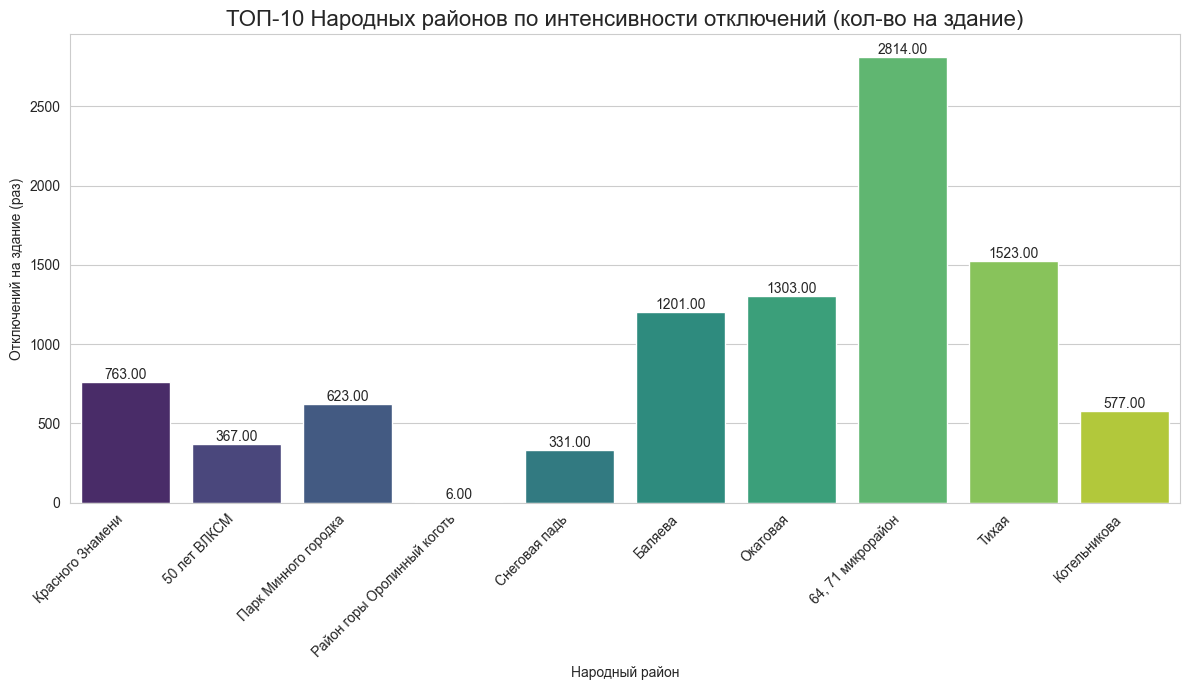

In [37]:
# ## 2.4. Анализ по Народным Районам (`folk_districts`)

# Повторяем анализ, используя народные районы. Эти данные более точно отражают восприятие местоположения пользователями.

# **Схема объединения:** # `blackouts_with_buildings` $\rightarrow$ `buildings` (по `folk_district_id`) $\rightarrow$ `folk_districts`

# 1. Объединение с Народным районом
blackouts_with_folk_geo = blackouts_with_buildings.merge(
    buildings_df[['id', 'folk_district_id']],
    left_on='building_id',
    right_on='id',
    how='inner'
)

# 2. Группировка и агрегация по Народному району
folk_district_analysis = blackouts_with_folk_geo.groupby('folk_district_id').agg(
    total_blackouts=('blackout_id', 'nunique'),
    median_duration_hours=('duration_hours', 'median')
)

folk_district_analysis = folk_district_analysis.reset_index().merge( # Сброс индекса
    folk_districts_df.rename(columns={'id': 'folk_district_id', 'name': 'folk_district_name'}),
    on='folk_district_id',
    how='left'
).set_index('folk_district_name').sort_values(by='total_blackouts', ascending=False)

# Дополнительно: Количество уникальных зданий в Народном районе
buildings_per_folk_district = buildings_df.groupby('folk_district_id')['id'].nunique().to_frame('total_buildings')
# ИСПРАВЛЕНИЕ: Сбрасываем индекс, чтобы он стал столбцом для слияния
buildings_per_folk_district = buildings_per_folk_district.reset_index() 

# Теперь buildings_per_folk_district содержит столбец 'folk_district_id'.
# folk_districts_df содержит 'id' и 'name'.
# Слияние для получения имени района:
buildings_per_folk_district = buildings_per_folk_district.merge(
    folk_districts_df, 
    left_on='folk_district_id', 
    right_on='id', 
    how='left'
).set_index('name')['total_buildings'] # Устанавливаем name как индекс

# Финальное слияние: используем left_index=True для слияния по индексу (названию района)
folk_district_analysis = folk_district_analysis.merge(
    buildings_per_folk_district, 
    left_index=True, 
    right_index=True, 
    how='left'
)

# Нормализация
folk_district_analysis['blackouts_per_building'] = folk_district_analysis['total_blackouts'] / folk_district_analysis['total_buildings']

print("--- ТОП-10 Народных районов по частоте отключений ---")
print(folk_district_analysis[['total_blackouts', 'blackouts_per_building', 'median_duration_hours']].head(10).round(2))


## 2.4.1. Визуализация ТОП-10 Народных районов по интенсивности отключений

top_10_folk = folk_district_analysis.sort_values(by='blackouts_per_building', ascending=False).head(10)

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='folk_district_name',
    y='total_blackouts',
    data=top_10_folk,
    hue='folk_district_name', # <-- Добавили hue = x
    palette='viridis',
    legend=False                # <-- Добавили legend=False
)

plt.title('ТОП-10 Народных районов по интенсивности отключений (кол-во на здание)', fontsize=16)
plt.xlabel('Народный район')
plt.ylabel('Отключений на здание (раз)')
plt.xticks(rotation=45, ha='right') # Поворот подписей для читаемости

# Добавление значений на столбцы
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

Ключевые наблюдения по Народным районам:

Лидеры по интенсивности (Частота на здание):

Районы Баляева (5.29 отключений на здание), Окатовая (5.19), и 64, 71 микрорайон (4.92) имеют критически высокую частоту отключений. Это означает, что в этих районах каждое здание сталкивается с отключениями 5 раз за анализируемый период.

Лидеры по абсолютному числу:

64, 71 микрорайон (2814 отключений) и Чуркин (2153 отключения) лидируют по общему количеству событий, что указывает на высокую концентрацию проблем.

Длительность отключений:Практически все районы из ТОП-10 имеют высокую медианную длительность отключений, колеблющуюся от 8.00 до 9.37 часов.